In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from expconfig import load_config
from icprem import PREM_IC_RHO, PREM_IC_VP
from sampling.priors import CompoundPrior
from tti.traveltimes import TravelTimeCalculator

In [2]:
rng = np.random.default_rng(1234)
normalisation = -1 / (2 * PREM_IC_RHO * (PREM_IC_VP * 1e3) ** 2)

In [3]:
cfg = load_config("../config.yaml")

prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(10_000, rng)

In [4]:
if prior.n == 7:
    shear = True
    N = True
elif prior.n == 6:
    shear = True
    N = False
elif prior.n == 5:
    shear = False
    N = False

In [5]:
noise_levels: dict[str, float] = {
    "ab": 0.95,
    "bc": 0.63,
    "cd": 0.29,
    "df": 0.95,
}

DATA_FILE = Path().resolve().parent / "data" / "brett2024_ic_traveltimes.parquet"

df = pd.read_parquet(DATA_FILE)
ic_in = np.stack(df.in_location.values)
ic_out = np.stack(df.out_location.values)
dt_over_t = (df.delta_t / df.inner_core_travel_time).values
sigma = df["reference_phase"].map(noise_levels).values

In [6]:
ttc = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=True, shear=shear, N=N
)
prior_predictive = ttc(prior_samples)
prior_predictive += rng.normal(
    loc=0.0,
    scale=sigma**2,
    size=prior_predictive.shape,
)
prior_predictive.shape

(10000, 7668)

Text(0.5, 0, 'Fractional Traveltime perturbation dt / t')

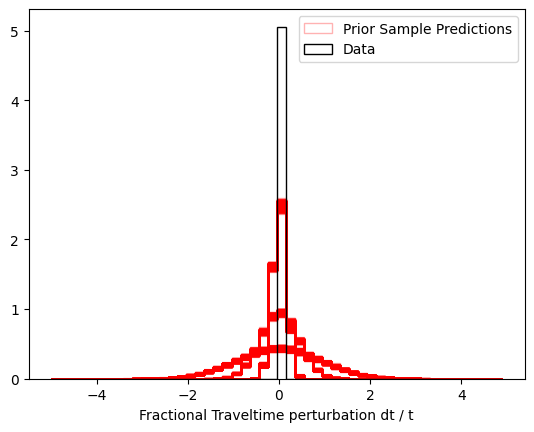

In [7]:
all_dists = np.vstack([prior_predictive, dt_over_t[None, :]])
hist_range = (all_dists.min(), all_dists.max())
common_kwargs = {
    "bins": 50,
    "histtype": "step",
    "range": hist_range,
    "density": True,
}
fig, ax = plt.subplots(
    1,
    1,
)
ax.hist(
    prior_predictive,
    **common_kwargs,
    color=np.full(prior_predictive.shape[1], "r"),
    alpha=0.3,
    label="Prior Sample Predictions",
)
ax.hist(
    dt_over_t,
    **common_kwargs,
    color="k",
    label="Data",
)
ax.legend()
ax.set_xlabel("Fractional Traveltime perturbation dt / t")